In [1]:
import matplotlib.pyplot as plt

"""
Small demo to illustrate how the plot function and the gridworld environment work
"""
import numpy as np
import optuna

from gridworld import *
from plot import *

In [ ]:
'EPISODES': 1, 'MAX_EPISODE_LENGTH': 15178, 'GAMMA': 0.8551585404890987, 'ALPHA': 0.9980504316555736

In [2]:
EPS = 0.1
#Hyperparameter found via optuna
ALPHA = 0.6660010689218203
GAMMA =  0.9955785729498876
EPISODES = 11620
MAX_EPISODE_LENGTH = 1544

ALPHA_LOW_EPISODE = 0.9980504316555736
GAMMA_LOW_EPISODE = 0.8551585404890987
MAX_EPISODE_LENGTH_LOW_EPISODE = 15178
EPISODES_LOW_EPISODE = 1

In [62]:
def select_action(episode, state, q_table):
    # do random action
    if np.random.random() < EPS/(0.5*(episode+1)):
        return np.random.randint(0, len(q_table[0]))
    # or do best action
    else:
        return np.argmax(q_table[state])


In [59]:
def qlearning(env, alpha, gamma, episodes, max_episode_length, init_reward):
    q_table = np.zeros((env.num_states(), env.num_actions()))
    q_table.fill(init_reward)
    learning_data={}
    cum_reward = 0
    # run a certain number of episodes
    for episode in range(episodes):
        state = env.reset()
        action = select_action(episode, state, q_table)

        done = False
        episode_length = 0

        # run episode until a goal state or the maximum number of steps has been reached
        while not done and episode_length < max_episode_length:
            next_state, reward, done = env.step(action)
            next_action = select_action(episode, next_state, q_table)

            # Q-Learning update rule
            delta = reward + gamma * np.max(q_table[next_state, next_action]) * (done < 0.5) - q_table[state, action]
            q_table[state, action] += alpha * delta
            cum_reward += alpha * delta
            
            state = next_state
            action = next_action
            episode_length += 1
            
        learning_data[episode] = [episode_length, cum_reward]

    return learning_data


In [35]:
def qlearning_optimize(trial):
    q_table = np.zeros((env.num_states(), env.num_actions()))
    EPISODES = trial.suggest_int('EPISODES', 300,1300)
    #INIT_VALUE = trial.suggest_int('INIT_VALUE',0,5)
    MAX_EPISODE_LENGTH = trial.suggest_int('MAX_EPISODE_LENGTH',100,20000)
    GAMMA = trial.suggest_float('GAMMA', 0,1)
    ALPHA = trial.suggest_float('ALPHA', 0,1)
    EPS = trial.suggest_float('EPS',0, 1)
    INIT_REWARD = trial.suggest_int('INIT_REWARD',0,20)
    DECAY = trial.suggest_float('DECAY',0,1)
    q_table.fill(INIT_REWARD)

    learning_data={}
    cum_reward = 0
    # run a certain number of episodes
    for episode in range(EPISODES):
        state = env.reset()
        action = select_action(DECAY, EPS, episode, state, q_table)

        done = False
        episode_length = 0

        # run episode until a goal state or the maximum number of steps has been reached
        while not done and episode_length < MAX_EPISODE_LENGTH:
            next_state, reward, done = env.step(action)
            next_action = select_action(DECAY, EPS,episode, next_state, q_table)

            # Q-Learning update rule
            delta = reward + GAMMA * np.max(q_table[next_state, next_action]) * (done < 0.5) - q_table[state, action]
            q_table[state, action] += ALPHA * delta
            cum_reward += ALPHA * delta
            
            state = next_state
            action = next_action
            episode_length += 1
            
        learning_data[episode] = [episode_length, cum_reward]

    return (cum_reward/MAX_EPISODE_LENGTH)


In [7]:
env = Random(size=12, water = 0, mountain=0.3)
for row in env.grid:
    print(row)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', '#', ' ', '#', '#', ' ']
['#', ' ', 'G', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
['#', ' ', ' ', ' ', ' ', ' ', ' ', '#', ' ', '#', ' ', ' ']
['#', ' ', '#', '#', '#', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', '#', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', '#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
['#', '#', '#', ' ', '#', ' ', '#', ' ', ' ', ' ', ' ', '#']
[' ', ' ', '#', '#', '#', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', '#', ' ', '#', ' ', ' ', ' ', ' ', ' ', '#', ' ', ' ']
[' ', ' ', '#', ' ', ' ', ' ', '#', ' ', ' ', '#', ' ', ' ']
['#', ' ', ' ', ' ', 'S', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


# Plot 1

In [73]:
#Hyperparameters not yet found via optuna
ALPHA = 0.6660010689218203
GAMMA =  0.9955785729498876
EPISODES = 11620
MAX_EPISODE_LENGTH = 1544
INIT_REWARD = 5

data1={}
envs1 = []

for i in range(10):
    env1 = Random(size=12, water=0.3, mountain=0)
    envs1.append(env)
    print("running environment {}".format(i))
    data1[i] = qlearning(env, ALPHA, GAMMA, EPISODES, MAX_EPISODE_LENGTH, INIT_REWARD)


running environment 0
running environment 1
running environment 2
running environment 3
running environment 4
running environment 5
running environment 6
running environment 7
running environment 8
running environment 9


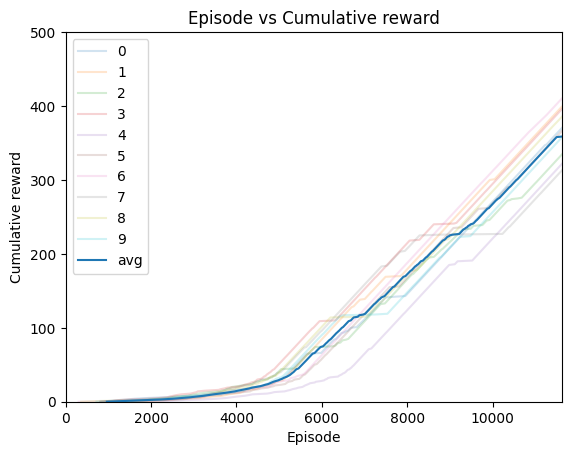

In [96]:
x_data_avg = np.zeros((EPISODES))
y_data_avg = np.zeros((EPISODES))

fig, ax = plt.subplots()
for i in range(data1.keys().__len__()):
    x_data = np.cumsum([value[0] for value in list(data1[i].values())])
    x_data_avg = [sum(x) for x in zip(x_data, x_data_avg)]

    ax.plot(x_data, range(len(x_data)), label=i, alpha = 0.2)

x_data_avg = [a/10 for a in x_data_avg]
#y_data_avg = [a/10 for a in y_data_avg]

ax.plot(x_data_avg, range(len(x_data)), label="avg")

# Adding labels and title
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
plt.title('Episode vs Cumulative reward')
plt.ylim(0,500)
plt.xlim(0,len(x_data))

plt.legend()

# Display the plot
plt.show()

# Plot 2: Cumulative reward vs. Amount of Steps

In [70]:
#Hyperparameters found via optuna
ALPHA = 0.6660010689218203
GAMMA =  0.9955785729498876
EPISODES = 11620
MAX_EPISODE_LENGTH = 1544
INIT_REWARD = 5

data2={}
envs2 = []

for i in range(10):
    env = Random(size=12, water=0, mountain=0.3)
    envs2.append(env)
    print("running environment {}".format(i))
    data2[i] = qlearning(env, ALPHA, GAMMA, EPISODES, MAX_EPISODE_LENGTH, INIT_REWARD)



running environment 0
running environment 1
running environment 2
running environment 3
running environment 4
running environment 5
running environment 6
running environment 7
running environment 8
running environment 9


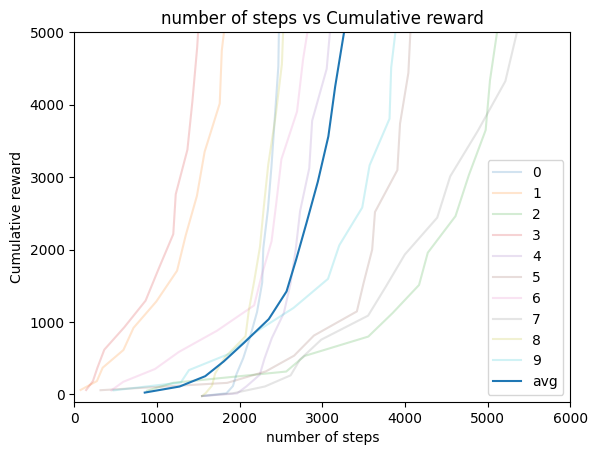

In [71]:
x_data_avg = np.zeros((EPISODES))
y_data_avg = np.zeros((EPISODES))
for i in range(data2.keys().__len__()):
    x_data = np.cumsum([value[0] for value in list(data2[i].values())])
    y_data = np.cumsum([value[1] for value in list(data2[i].values())])
    
    x_data_avg = [sum(x) for x in zip(x_data, x_data_avg)]
    
    y_data_avg = [sum(y) for y in zip(y_data, y_data_avg)]
    
    plt.plot(x_data, y_data, label=i, alpha=0.2)

x_data_avg = [a/10 for a in x_data_avg]
y_data_avg = [a/10 for a in y_data_avg]

plt.plot(x_data_avg, y_data_avg, label="avg")

# Adding labels and title
plt.xlabel('number of steps')
plt.ylabel('Cumulative reward')
plt.title('number of steps vs Cumulative reward')
plt.ylim(-100,5000)
plt.xlim(0,6000)

plt.legend()

# Display the plot
plt.show()